In [364]:
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [365]:
words = open("../../data/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [366]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

block_size = 4
def build_dataset(words, block_size = block_size):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


# E01: Tune the hyperparameters of the training to beat validation loss of 2.2

In [375]:
# Hyperparameters
emb_size = 12
in_size = block_size * emb_size
hidden_size = 256
out_size = 27

lr = 0.1
lambda_ = 0.01
batch_size = 256

In [376]:
g = torch.Generator().manual_seed(12344321)
C = torch.randn((out_size, emb_size), generator = g)
W1 = torch.randn((in_size, hidden_size), generator = g)
b1 = torch.randn(hidden_size, generator = g)
W2 = torch.randn((hidden_size, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

# use the new learning rate
lossi = []
stepi = []

number of params = 19807


In [377]:
# Training Loop
for i in range(300000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Ytr[ix])

    # add regularization
    loss += lambda_ * (W1 ** 2).mean() + lambda_ * (W2 ** 2).mean()

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    used_lr = lr
    if i > 20000 and i < 60000:
        used_lr = 0.01
    elif i >= 200000:
        used_lr = 0.001
    elif i >= 260000:
        used_lr = 0.0001
        
    for p in parameters:
        p.data -= used_lr * p.grad

    # track loss
    lossi.append(loss.log10().item())
    stepi.append(i)

    if i % 10000 == 0:
        print(f"mini batch {i} | loss {loss.item()} at lr {used_lr}")
            

mini batch 0 | loss 29.285480499267578 at lr 0.1
mini batch 10000 | loss 2.3990862369537354 at lr 0.1
mini batch 20000 | loss 2.283390522003174 at lr 0.1
mini batch 30000 | loss 2.2350196838378906 at lr 0.01
mini batch 40000 | loss 2.2718069553375244 at lr 0.01
mini batch 50000 | loss 2.3221569061279297 at lr 0.01
mini batch 60000 | loss 2.236496686935425 at lr 0.1
mini batch 70000 | loss 2.18037748336792 at lr 0.1
mini batch 80000 | loss 2.200941324234009 at lr 0.1
mini batch 90000 | loss 2.226801872253418 at lr 0.1
mini batch 100000 | loss 2.171529769897461 at lr 0.1
mini batch 110000 | loss 2.11014461517334 at lr 0.1
mini batch 120000 | loss 2.1589324474334717 at lr 0.1
mini batch 130000 | loss 2.030834674835205 at lr 0.1
mini batch 140000 | loss 2.276352882385254 at lr 0.1
mini batch 150000 | loss 2.075453281402588 at lr 0.1
mini batch 160000 | loss 2.047902822494507 at lr 0.1
mini batch 170000 | loss 2.053204298019409 at lr 0.1
mini batch 180000 | loss 2.163881778717041 at lr 0.1


used learning rates:[0.1, 0.05, 0.05, 0.001] 30k steps each

Training set loss 2.0418529510498047
Dev set loss 2.1073224544525146


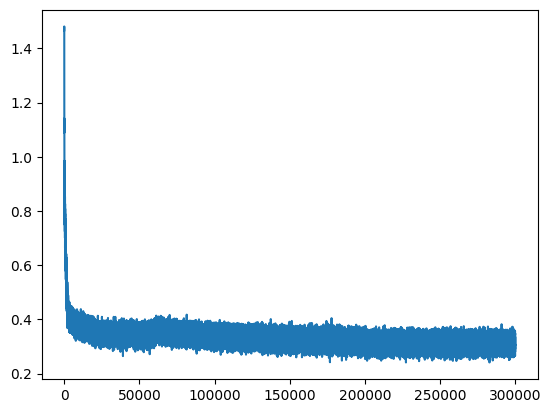

In [379]:
# Evaluation

# 1) Training Loss
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# 2) Test Loss
# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

# 3) Plot Mini Batch Loss[]
plt.plot(lossi);

# E02: intialization of the network.

## (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [380]:
# Evaluation
# 1) Training Loss
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# 2) Dev Loss
# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

Training set loss 3.3361361026763916
Dev set loss 3.334118366241455


## (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

reduce the std of the initialization to 0.01

In [381]:
torch.nn.init.normal_(C, 0, 0.01)
torch.nn.init.normal_(W1, 0, 0.01)
torch.nn.init.normal_(b1, 0, 0.01)
torch.nn.init.normal_(W2, 0, 0.01)
torch.nn.init.normal_(b2, 0, 0.01)

# use Xtr and Ytr
X = Xtr
Y = Ytr

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 19807


In [384]:
# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # now size of emb is (32, 3, 2) again

# Forward Pass
emb = C[Xtr[ix]]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr[ix])

# add regularization
loss += lambda_ * (W1 ** 2).mean() + lambda_ * (W2 ** 2).mean()
print(f"starting loss | loss {loss.item()}")
            

starting loss | loss 3.294675588607788


# E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?
Regularization is used above, however, it had a small effect on the validation loss.